## Plot results

The purpose of this notebook is to visualize models' performances singlehandedly and/or with respect to each other's. It expects the selected models to have already gone through training using the `run_exp_script.py` script.

In [7]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from utils import plot_utils as plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Train/Val Plot

In [2]:
from models.from_config import build_model
from data_handlers.csv_dataset import CustomDatasetFromDataFrame
from test import test_r2
import torch

CKPT_PATH = 'models/checkpoints/'

In [4]:
RESULT_PATH = 'models/results/rn18_ms_e2e_l7_yeh.pkl'
# Load Results
with open(RESULT_PATH, 'rb') as f:
    results = pickle.load(f)

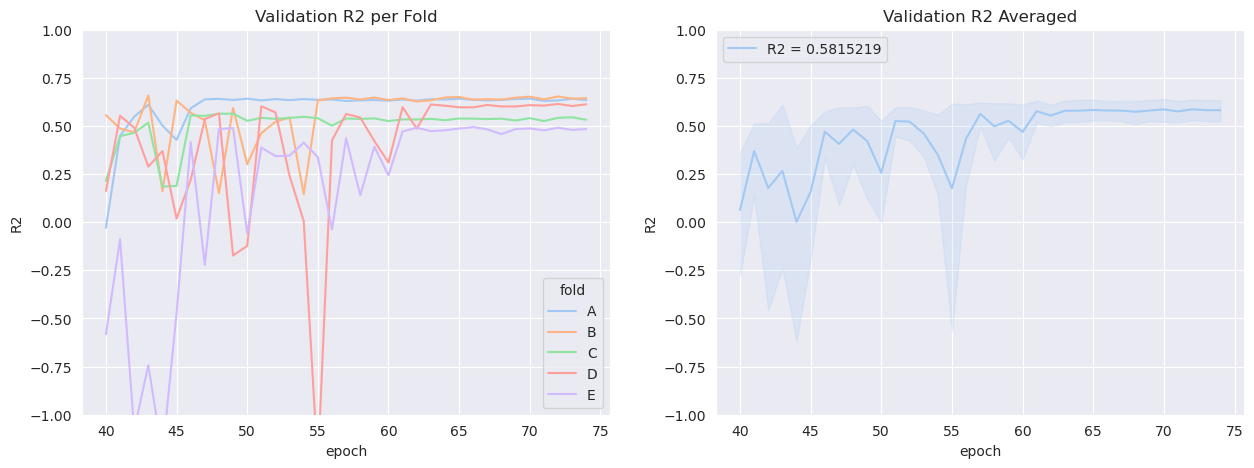

In [7]:
# VAL PERFORMANCES
for config in results:
    multi_val_dict = plot.extract_crossval_results(results=results[config], var='test_r2', new_var="R2")
    df = pd.DataFrame.from_dict(multi_val_dict)
    df=df[df.epoch >= 40] # skip unstable first epochs
    # Figures
    sns.set_palette('pastel')
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2,figsize=(15, 5))
    ax[0].set_title('Validation R2 per Fold')
    ax[1].set_title('Validation R2 Averaged')
    sns.lineplot(ax=ax[0], data=df, x="epoch", y="R2", hue="fold", palette="pastel").set(ylim=(-1, 1))
    sns.lineplot(ax=ax[1], data=df, x="epoch", y="R2", legend=False).set(ylim=(-1,1.))

    # Add R2 value
    df2 = df[df['epoch']==df['epoch'].max()]
    ax[1].legend(title='', loc='upper left', labels=['R2 = '+str(df2.R2.mean())])


### Test Plots

In [9]:
# TEST PERFORMANCES

with open( 'configs/resnet18_ms_e2e_l7_yeh_gs.json' ) as f:
        model_config = json.load(f)
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = 'data/landsat_7/'

with open( 'configs/default_config.pkl','rb') as f:
    data_config = pickle.load(f)
with open(data_config['fold'], 'rb') as f:
    fold_dict = pickle.load(f)

dataset = pd.read_csv(data_config['csv'])
ckpt = CKPT_PATH+'rn18_ms_e2e_l7_yeh_1_64_0_'
r2_mean = 0.
for fold in ['A','B','C','D','E']:
    print(fold)
    loadpath = ckpt+fold+'.pth'
    model = build_model(model_config,device)
    model.load_state_dict(torch.load(loadpath))
    val_dataset = CustomDatasetFromDataFrame(dataset.iloc[fold_dict[fold]['test']], DATA_DIR, transform=data_config['test_transform'],tile_max=data_config['max'],
                                    tile_min=data_config['min'] )  
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=256,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    r2 = test_r2(model, val_loader, device)
    r2 = r2.cpu().item()
    r2_mean+=r2
r2_mean/=5
print(r2_mean)

A
B
C
D
E
0.5834724187850953


In [25]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics import r2_score
import test
import json
data_config_filename='configs/default_config.pkl'
save_path='results/ms_1_64_0.csv'
with open('data/dhs_incountry_folds.pkl','rb') as f:
    fold_dict = pickle.load(f)

In [42]:
model_config_filename = 'configs/resnet18_ms_1_64_0.json'
df_test = test.main(
    write_path=save_path,
    data_config_filename=data_config_filename,
    network_config_filename=model_config_filename,
    dataset=pd.read_csv('data/dataset.csv')
)

In [58]:
r2_all = r2_score(df_test['wealthpooled'], df_test['predicted_wealth'])
r2_all

0.5344023147058381

Text(-1.5, 1.5, 'R2 = 0.5344')

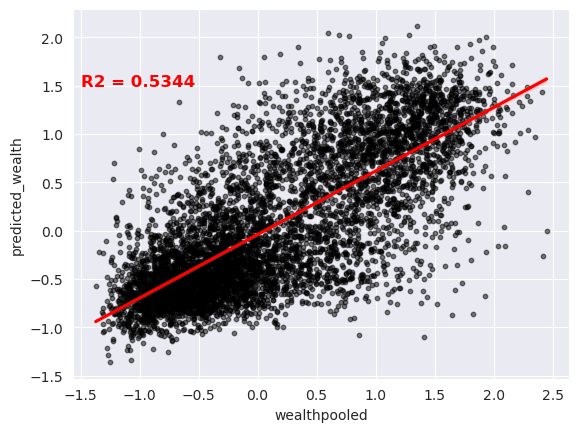

In [69]:
sns.color_palette()
sns.regplot(x="wealthpooled", y="predicted_wealth", data=df_test,x_ci='sd', marker='o', scatter_kws={'alpha':0.5,'color':'black', 's':10}, line_kws={'color':'red'})
plt.text(-1.5,1.5, 'R2 = ' + str(round(r2_all,4)), fontsize='large', weight='bold', color='red')

**Countrywise**

In [60]:
bg_map = gpd.read_file('data/africa.json')

/home/matthieu/anaconda3/envs/mpa_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


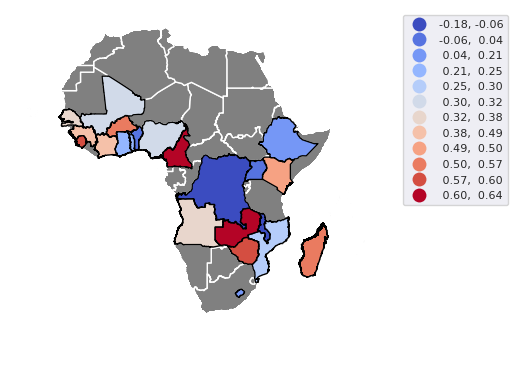

In [61]:
plot.country_plot(
    bg_map=bg_map,
    data=df_test,
    cmap='coolwarm',
    bg_color='gray',
    edgecolor='white'
)

**Year Difference**

3527 2966


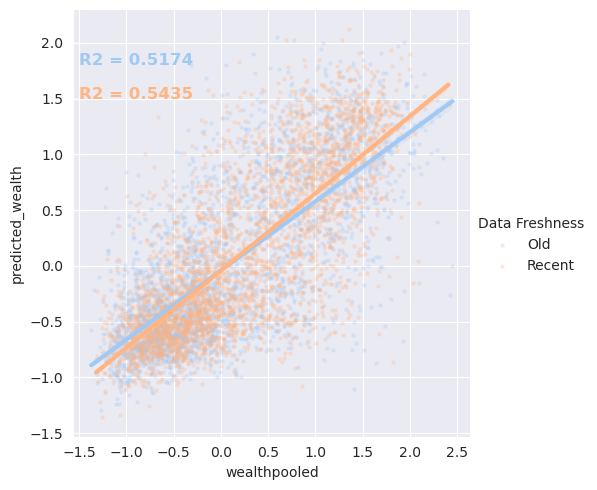

In [67]:
plot.split_regplot(
    data=df_test,
    col_to_split='year',
    newcol_name='Data Freshness',
    split_val=df_test.year.median(),
    labelinf='Old',
    labelsup='Recent',
    scatter_kws={'alpha':0.2, 's':5},
    line_kws= {'alpha':1., 'linewidth':3}
    )

**Urban vs. Rural**

sample size: 3632
1378 2254


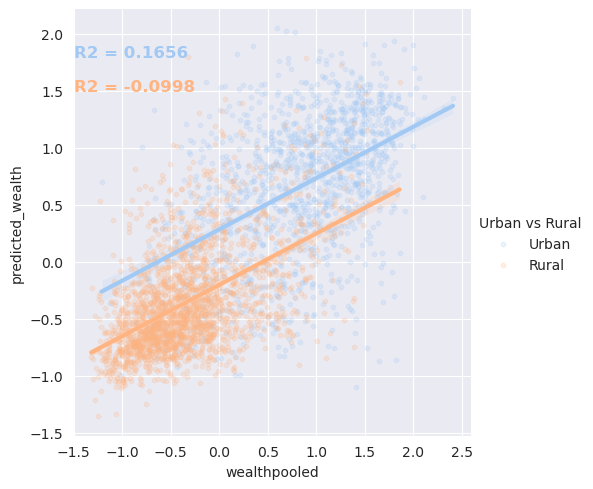

In [68]:
df_test_ur = df_test[df_test['urban_rural']!=-1]
print('sample size:', len(df_test_ur))
df_test_ur = df_test_ur.rename({'urban_rural':'Urban vs Rural'},axis=1)
plot.split_regplot(
    data=df_test_ur,
    col_to_split='Urban vs Rural',
    newcol_name='Urban vs Rural',
    split_val=1.,
    labelinf='Rural',
    labelsup='Urban',
    scatter_kws={'alpha':0.2, 's':10},
    line_kws= {'alpha':1., 'linewidth':3}
    )